利用ARMA预测用户数量变化

1.数据显示

0       80630
1      101503
2       91477
3      107134
4      153880
        ...  
354     20879
355     20160
356     20001
357     21204
358     20380
Name: Number of  reported results, Length: 359, dtype: int64


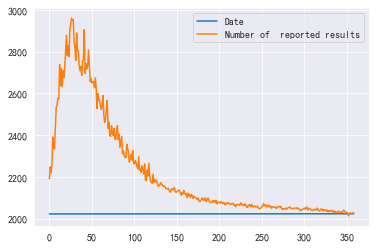

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#导入数据
data=pd.read_excel(r"E:\JM\2023JM\data\Date(2).xlsx")
print(data[u'Number of  reported results'])


#查看原始数据时序图
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
data.plot()
plt.show()

2.ADF平稳性检验
    如果检验输出的 p-value 较大，就表明数据不具有平稳性。

ADF检验结果:
Test Statistic                  -3.921347
p-value                          0.001883
Number of Lags Used             17.000000
Number of Observations Used    341.000000
Critical Value (1%)             -3.449673
Critical Value (5%)             -2.870053
Critical Value (10%)            -2.571306
dtype: float64


C:\Users\Sekuni\AppData\Local\Temp\ipykernel_31088\3957618293.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(data[u'Number of  reported results']).show()


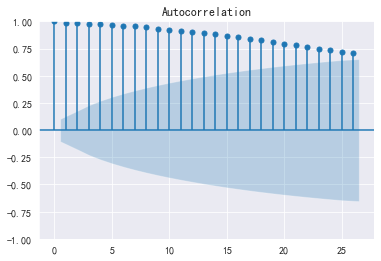

In [2]:
import numpy as np
#查看原始数据自相关系数
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data[u'Number of  reported results']).show()

#定义ADF输出格式化函数，结果中Test Statistic大于1%置信水平值，P>0.05,liucun存在单位根，序列不平稳
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print('ADF检验结果:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#对数据集使用ADF检验
adf_test(data[u'Number of  reported results'])

3、如果时间序列不平稳，需进行差分转换，得到差分之后的平稳序列再进行预测
（1）如果明确需一阶差分的话

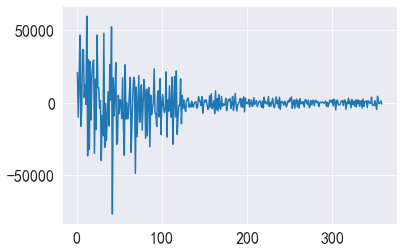

ADF检验结果:
Test Statistic                  -4.234245
p-value                          0.000576
Number of Lags Used             17.000000
Number of Observations Used    340.000000
Critical Value (1%)             -3.449730
Critical Value (5%)             -2.870079
Critical Value (10%)            -2.571319
dtype: float64


C:\Users\Sekuni\AppData\Local\Temp\ipykernel_31088\1104320635.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(D_data).show() #自相关图
D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Sekuni\AppData\Local\Temp\ipykernel_31088\1104320635.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(D_data).show() #偏自相关图


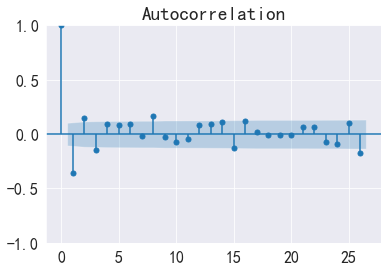

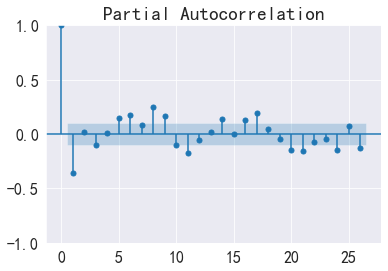

In [5]:
#ADF检验结果说明原始序列不平稳，需进行差分，一阶 差分
D_data = data[u'Number of  reported results'].diff(1).dropna()
D_data.columns = [u'Number']
D_data.plot() #时序图
plt.show()
plot_acf(D_data).show() #自相关图

#对一阶差分后的序列进行单位根检验，P值小于0.05，一阶差分后的序列平稳
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(D_data).show() #偏自相关图
adf_test(D_data)

(2)如果不明确，需进一步确定需几阶差分，再进行AR、MA定阶
选取最小AIC的阶

In [6]:
#定好差分阶数后，对模型p，q定阶，可用aic或bic指标，ARIMA(data, (0, 0, 1)).fit().bic
from statsmodels.tsa.arima.model import ARIMA
pmax =int(5)    #一般阶数不超过 length /10
qmax = int(5)
aic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        md=ARIMA(D_data, order=(p, 0, q))
        temp.append(md.fit(method_kwargs={'maxiter':300}).bic)
    aic_matrix.append(temp)

aic_matrix = pd.DataFrame(aic_matrix)   #将其转换成Dataframe 数据结构
print(aic_matrix)

p,q = aic_matrix.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'AIC 最小的p值 和 q 值：%s,%s' %(p,q))


D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was prov

             0            1            2            3            4  \
0  9548.170905  7761.362836  7766.725806  7788.740408  7766.295318   
1  7755.721006  7761.831042  7768.208258  7790.629274  7731.985006   
2  7761.442002  7766.828352  7774.221298  7764.721515  7755.010631   
3  7763.793035  7770.331635  7747.925023  7730.657555  7726.090164   
4  7770.344785  7750.919978  7715.250684  7722.193223  7730.363763   
5  7767.933636  7744.175729  7748.708467  7754.019694  7730.680011   

             5  
0  7728.014458  
1  7734.460870  
2  7734.991098  
3  7742.728039  
4  7747.413715  
5  7723.816933  
AIC 最小的p值 和 q 值：4,2


D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:     Number of  reported results   No. Observations:                  358
Model:                          ARIMA(4, 1, 2)   Log Likelihood               -3837.384
Date:                         Tue, 21 Feb 2023   AIC                           7688.767
Time:                                 03:12:04   BIC                           7715.911
Sample:                                      0   HQIC                          7699.563
                                         - 358                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2645      0.145     -1.827      0.068      -0.548       0.019
ar.L2         -0.1414      0.080     -1.776      0.076     

D:\ProgramLanguages\Python\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: x and y must have same first dimension, but have shapes (359,) and (358,)

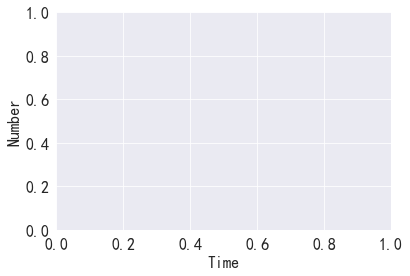

In [7]:
from statsmodels.tsa.arima.model import ARIMA
md = ARIMA(D_data, order=(4, 1, 2)).fit()
print(md.summary())
prediction= md.predict()
future_forecast = md.forecast(80)
# print(prediction)
for i,num in enumerate(future_forecast):
    print(num)
x=np.linspace(0,359,359)
real=np.array([])
for i in data[u'Number of  reported results']:
    real=np.append(real,i)
plt.rc('font',size=16)
plt.xlabel("Time")
plt.ylabel("Number")
plt.plot(x,prediction,label='Predict')
plt.plot(x,real,label='Real')
plt.legend()
plt.show()

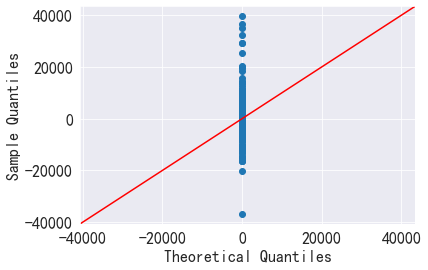

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np


# 查看前10个数据

# 创建 Q-Q 图，并增加 45度线
fig = sm.qqplot(prediction, line='45')
plt.show()


In [57]:
import json
predict=[]
for i in prediction:
    predict.append(i)
with open(r"E:\JM\2023JM\data\new.json",'w') as f:
    json.dump(predict, f)

绘制BIC热力图

[[7799, 7771, 7778, 7804, 7790, 7761.10128], [7767, 7774, 7779, 7755, 7758, 7764.981071], [7773, 7777, 7785, 7763, 7756, 7742.479698], [7777, 7784, 7778, 7751, 7759, 7744.830569], [7782, 7751, 7746, 7731, 7738, 7747.424298], [7780.693844, 7750.498143, 7752.279242, 7737.400204, 7741.011284, 7745.157777]]


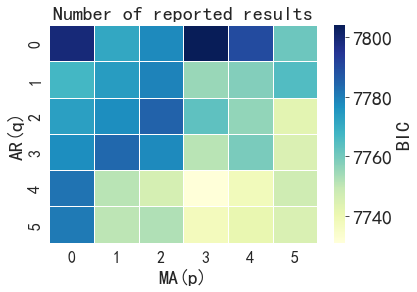

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

data = [[7799.191433, 7771.560835, 7778.398652, 7804.623291, 7790.896910,7761.101280],
        [7767.713269, 7774.643991, 7779.552978, 7755.238162, 7758.031427,7764.981071],
        [7773.495560, 7777.273213, 7785.566231, 7763.005554, 7756.705786,7742.479698],
        [7777.500062, 7784.029874, 7778.186996, 7751.281563, 7759.612024,7744.830569],
        [7782.004000, 7751.235772, 7746.682246, 7731.643679, 7738.280965,7747.424298],
        [7780.693844, 7750.498143, 7752.279242, 7737.400204, 7741.011284,7745.157777]]

for i in range(5):
    for j in range(5):
        data[i][j]=int(data[i][j])
print(data)
#练习的数据：
data = pd.DataFrame(data)

#绘制热度图：
tick_ = np.arange(-20, 20, 5).astype(float)
dict_ = {'orientation': 'vertical', "label": "color  \
scale", "drawedges": True, "ticklocation": "right", "extend": "min", "filled": True, "alpha": 0.8, "cmap": "hot_r",
         "ticks": tick_, "spaci,linewidths=0.5ng": 'proportional'}
#绘制添加数值和线条的热度图：
cmap = sns.heatmap(data, linewidths=0.8,cmap="YlGnBu")
plt.xlabel("MA(p)", size=20)
plt.ylabel("AR(q)", size=20)
plt.title("Number of reported results", size=20)

#调整色带的标签：
cbar = cmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel(ylabel="BIC", size=20, loc="center")
plt.savefig(r"E:\JM\2023JM\data\picture\1.1.heatmap2.jpg",dpi=500,bbox_inches = 'tight')
plt.show()